In [1]:
### ------------------------------- ###
### MovieLens Analysis ###
### Author: Asim Jamal ###
### Dataset link : https://files.grouplens.org/datasets/movielens/ml-100k.zip ###
### ------------------------------- ###

In [2]:
#Installing Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

In [3]:
# ------------------------------
# Load Data
# ------------------------------
# u.data: user_id, item_id, rating, timestamp
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "movie_id", "rating", "timestamp"])

# u.item: movie_id | title | release_date | video_release | imdb_url | genres...
movies = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
movies = movies.iloc[:, :24]  # first 24 cols only
movies.columns = ["movie_id", "title", "release_date", "video_release", "imdb_url"] + [f"genre_{i}" for i in range(19)]

In [4]:
# Merge ratings with movie info
data = ratings.merge(movies[["movie_id", "title", "release_date"]], on="movie_id")

# Convert release_date to year
data["year"] = pd.to_datetime(data["release_date"], errors="coerce").dt.year

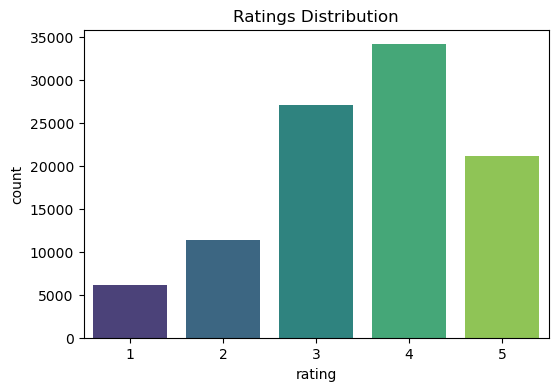

In [5]:
# ------------------------------
# 1. Rating distribution
# ------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=data, palette="viridis")
plt.title("Ratings Distribution")
plt.show()

In [7]:
# ------------------------------
# 2. Top/Bottom 10 movies by avg rating (min 50 ratings)
# ------------------------------
movie_stats = data.groupby("title").agg(
    avg_rating=("rating","mean"),
    n_ratings=("rating","count")
).reset_index()
filtered = movie_stats[movie_stats["n_ratings"] >= 50]

top10 = filtered.sort_values("avg_rating", ascending=False).head(10)
bottom10 = filtered.sort_values("avg_rating", ascending=True).head(10)

print("Top 10 Movies by Average Rating:\n", top10)
print("\nBottom 10 Movies by Average Rating:\n", bottom10)

Top 10 Movies by Average Rating:
                                                   title  avg_rating  n_ratings
318                               Close Shave, A (1995)    4.491071        112
1281                            Schindler's List (1993)    4.466443        298
1652                         Wrong Trousers, The (1993)    4.466102        118
273                                   Casablanca (1942)    4.456790        243
1597  Wallace & Gromit: The Best of Aardman Animatio...    4.447761         67
1317                   Shawshank Redemption, The (1994)    4.445230        283
1215                                 Rear Window (1954)    4.387560        209
1572                         Usual Suspects, The (1995)    4.385768        267
1398                                   Star Wars (1977)    4.358491        583
3                                   12 Angry Men (1957)    4.344000        125

Bottom 10 Movies by Average Rating:
                                        title  avg_rating  n


Top 10 Most Rated Movies:
                               title  avg_rating  n_ratings
1398               Star Wars (1977)    4.358491        583
333                  Contact (1997)    3.803536        509
498                    Fargo (1996)    4.155512        508
1234      Return of the Jedi (1983)    4.007890        507
860                Liar Liar (1997)    3.156701        485
460     English Patient, The (1996)    3.656965        481
1284                  Scream (1996)    3.441423        478
1523               Toy Story (1995)    3.878319        452
32             Air Force One (1997)    3.631090        431
744   Independence Day (ID4) (1996)    3.438228        429


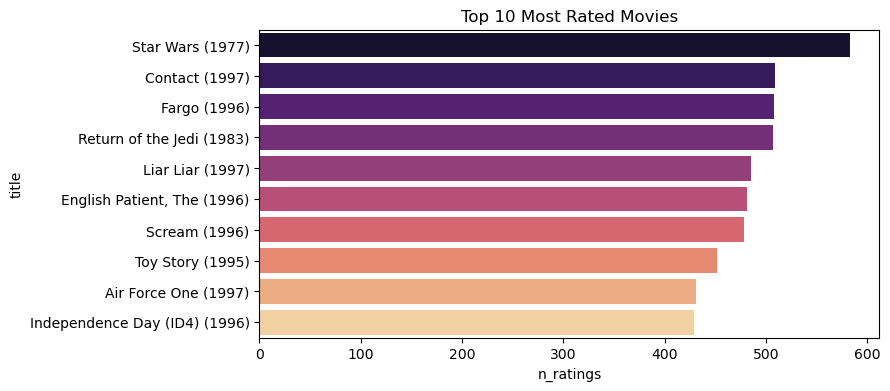

In [8]:
# ------------------------------
# 3. Top 10 most rated movies
# ------------------------------
most_rated = movie_stats.sort_values("n_ratings", ascending=False).head(10)
print("\nTop 10 Most Rated Movies:\n", most_rated)

plt.figure(figsize=(8,4))
sns.barplot(x="n_ratings", y="title", data=most_rated, palette="magma")
plt.title("Top 10 Most Rated Movies")
plt.show()


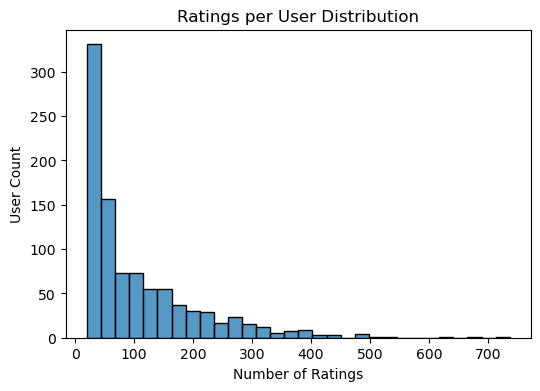

In [9]:
# ------------------------------
# 4. Ratings per user distribution
# ------------------------------
user_activity = data.groupby("user_id")["rating"].count()

plt.figure(figsize=(6,4))
sns.histplot(user_activity, bins=30, kde=False)
plt.title("Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("User Count")
plt.show()

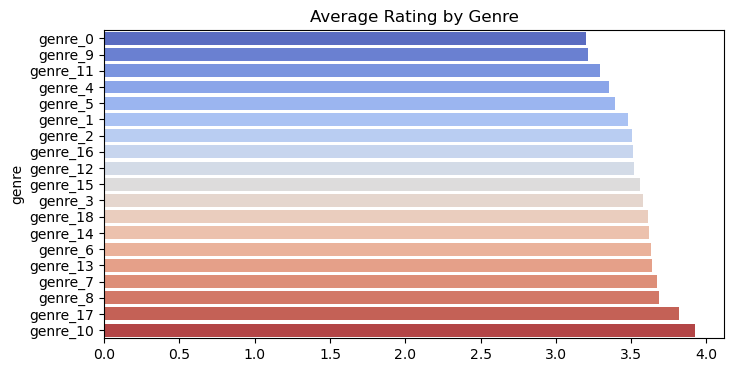

In [10]:
# ------------------------------
# 5. Avg rating by genre
# ------------------------------
# Extract genre columns
genre_cols = [c for c in movies.columns if "genre_" in c]
movie_genres = movies[["movie_id"] + genre_cols]

# Merge with ratings
genre_data = ratings.merge(movie_genres, on="movie_id")

# Melt to long format
genre_melt = genre_data.melt(
    id_vars=["rating"], 
    value_vars=genre_cols, 
    var_name="genre", 
    value_name="is_genre"
)

# Filter only rows where genre applies
genre_melt = genre_melt[genre_melt["is_genre"] == 1]

avg_rating_genre = genre_melt.groupby("genre")["rating"].mean().sort_values()

plt.figure(figsize=(8,4))
sns.barplot(x=avg_rating_genre.values, y=avg_rating_genre.index, palette="coolwarm")
plt.title("Average Rating by Genre")
plt.show()

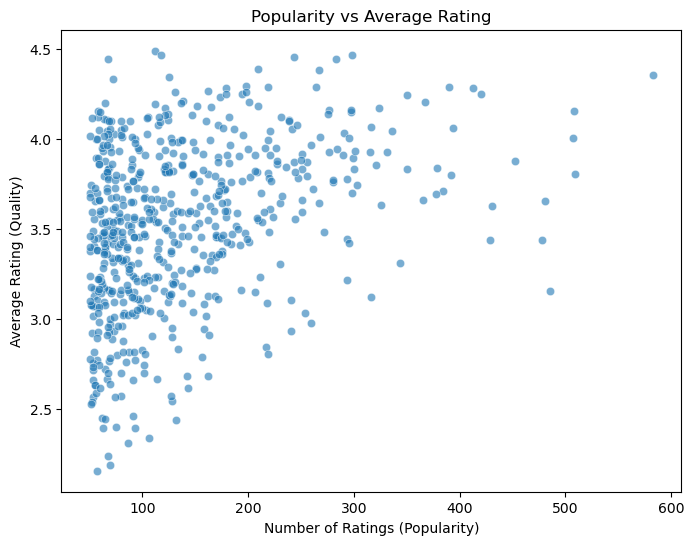

In [11]:
# ------------------------------
# 6. Popularity vs Quality scatterplot
# ------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x="n_ratings", y="avg_rating", data=filtered, alpha=0.6)
plt.title("Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Popularity)")
plt.ylabel("Average Rating (Quality)")
plt.show()

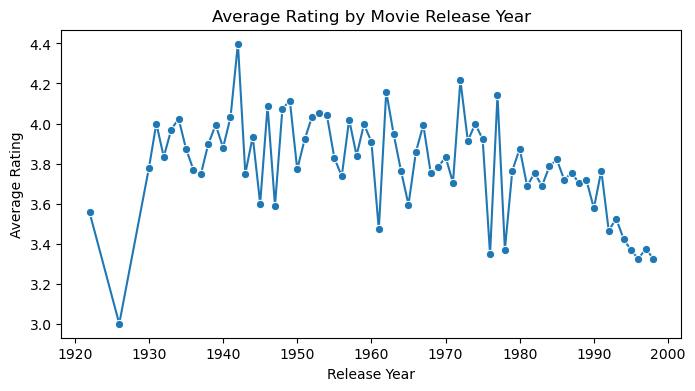

In [12]:
# ------------------------------
# 7. Average rating trend over release year
# ------------------------------
yearly = data.groupby("year")["rating"].mean().dropna()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Average Rating by Movie Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()